In [26]:
from requests import get, post
import json
import time
import pandas as pd
import os
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as mp
from matplotlib.pyplot import cm

from dune_client.types import QueryParameter
from dune_client.client import DuneClient
from dune_client.query import Query



In [27]:
# Rewards article uses df_orch_monthly created towards end of this notebook (the end of this notebook has some deep dives into network level metrics and orchestrator deep dives (fees, tickets,stakerewards etc.) 
# Dune query has all orchestrator data -> merge with pricing data from coingecko for usd values, make some edits (e.g. around missing reward cut/fee share data) and group to daily and monthly timeseries

In [28]:
def gini(list_of_values):
    n = len(list_of_values)
    sorted_list = sorted(list_of_values)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2.
    return (fair_area - area) / fair_area * (n-1)/n

def convert_blocktime(blocktime, **kwargs):
    delta = kwargs.get('delta',6)
    if blocktime is None:
        return None
    else:
        timestr = blocktime.replace('T',' ').replace('Z','')
        return datetime.datetime.strptime(timestr[:-delta], "%Y-%m-%d %H:%M:%S")

def get_rolling_avg(series,window):
    out=[]
    for i in range(0,len(series)):
        if i<window:
            if i==0:
                out.append(series[i])
            else:
                out.append(np.mean(series[:i]))
        else:
            out.append(np.mean(series[i-window:i]))
    return out
    
def add_datestr_col(df, date_col, **kwargs):
    delta = kwargs.get('delta',6)
    if 'datestr' in df.keys():
        df['datestr' + date_col]=[convert_blocktime(df[date_col].iloc[i],delta=delta) for i in range(0, len(df))]
    else:
        df['datestr']=[convert_blocktime(df[date_col].iloc[i],delta=delta) for i in range(0, len(df))]

def clean_address(df,address_col):
    df[address_col+'_clean'] = [df[address_col].iloc[i].replace('\\x','0x') for i in range(0,len(df))]

In [29]:
#from https://dune.com/docs/api/quick-start/api-py/
BASE_URL = "https://api.dune.com/api/v1/"

def make_api_url(module, action, ID):
    """
    We shall use this function to generate a URL to call the API.
    """

    url = BASE_URL + module + "/" + str(ID) + "/" + action

    return url

def execute_query(query_id, engine="medium"):
    """
    Takes in the query ID and engine size.
    Specifying the engine size will change how quickly your query runs. 
    The default is "medium" which spends 10 credits, while "large" spends 20 credits.
    Calls the API to execute the query.
    Returns the execution ID of the instance which is executing the query.
    """

    url = make_api_url("query", "execute", query_id)
    params = {
        "performance": engine,
    }
    response = post(url, headers=HEADER, params=params)
    execution_id = response.json()['execution_id']

    return execution_id


def execute_query_with_params(query_id, param_dict):
    """
    Takes in the query ID. And a dictionary containing parameter values.
    Calls the API to execute the query.
    Returns the execution ID of the instance which is executing the query.
    """

    url = make_api_url("query", "execute", query_id)
    response = post(url, headers=HEADER, json={"query_parameters" : param_dict})
    execution_id = response.json()['execution_id']

    return execution_id


def get_query_status(execution_id):
    """
    Takes in an execution ID.
    Fetches the status of query execution using the API
    Returns the status response object
    """

    url = make_api_url("execution", "status", execution_id)
    response = get(url, headers=HEADER)

    return response


def get_query_results(execution_id):
    """
    Takes in an execution ID.
    Fetches the results returned from the query using the API
    Returns the results response object
    """

    url = make_api_url("execution", "results", execution_id)
    response = get(url, headers=HEADER)

    return response


def cancel_query_execution(execution_id):
    """
    Takes in an execution ID.
    Cancels the ongoing execution of the query.
    Returns the response object.
    """

    url = make_api_url("execution", "cancel", execution_id)
    response = get(url, headers=HEADER)

    return response

def run_query(query_id,**kwargs):
    parameters = kwargs.get('parameters',{})
    status_ping_interval = kwargs.get('status_ping_interval',30)
    query_size = kwargs.get('query_size','medium')
    if len(parameters)>0:
        execution_id = execute_query_with_params(query_id,parameters)
    else:
        execution_id = execute_query(query_id,query_size)
    
    # response = get_query_results(execution_id)
    status = get_query_status(execution_id)
    timesum=0
    while (status.json()['state'] == 'QUERY_STATE_EXECUTING') & (timesum<3600):
        print("Waiting for query to finish...")
        time.sleep(status_ping_interval)
        timesum+=status_ping_interval
        status = get_query_status(execution_id)
    
    response = get_query_results(execution_id)
    if response.json()['state'] == 'QUERY_STATE_COMPLETED':
        return pd.DataFrame(response.json()['result']['rows'])
    else:
        print(response.json()['state'])
        print('No output')
        return None

In [30]:
api_key='...' # enter dune api key 

HEADER = {"x-dune-api-key" : api_key}

In [31]:
#prices from coingecko
df_prices_lpt = pd.read_csv('csvs/lpt-usd-max.csv')
add_datestr_col(df_prices_lpt,'snapped_at',delta=4)
df_prices_eth = pd.read_csv('csvs/eth-usd-max.csv')
add_datestr_col(df_prices_eth,'snapped_at',delta=4)

In [149]:
df_prices_lpt[df_prices_lpt.datestr<'2019-01-01']

,snapped_at,price,market_cap,total_volume,datestr
0,2018-12-11 00:00:00 UTC,1.831718,0.0,16.283704,2018-12-11
1,2018-12-12 00:00:00 UTC,0.988577,0.0,82.742665,2018-12-12
2,2018-12-13 00:00:00 UTC,1.782487,0.0,1002.859348,2018-12-13
3,2018-12-14 00:00:00 UTC,1.158131,0.0,1633.613471,2018-12-14
4,2018-12-15 00:00:00 UTC,1.525140,0.0,65.507989,2018-12-15
5,2018-12-16 00:00:00 UTC,1.518855,0.0,73.800234,2018-12-16
6,2018-12-17 00:00:00 UTC,1.714364,0.0,21.948734,2018-12-17
7,2018-12-18 00:00:00 UTC,1.723382,0.0,2706.295622,2018-12-18
8,2018-12-19 00:00:00 UTC,2.008829,0.0,202.169976,2018-12-19
9,2018-12-20 00:00:00 UTC,4.697716,0.0,5459.151624,2018-12-20


In [33]:
#dates of changes on orchestrator limits
dct_orchestrator_limits = {'dates':['2018-07-30 00:00:00','2019-02-25 00:00:00','2020-01-13 00:00:00 ','2022-02-11 00:00:00'],
'limit':[5,17,31,100]}
df_orchestrator_limits = pd.DataFrame.from_dict(dct_orchestrator_limits)
add_datestr_col(df_orchestrator_limits,'dates', delta=1)



In [34]:
#dune queries
orchestrator_daily_query=1398261 #Orchestrator data (stake, rewards, fees, age etc.) per day (and chain)


In [37]:
df_orchestrators_daily = run_query(orchestrator_daily_query)
add_datestr_col(df_orchestrators_daily,'dateday', delta=8)
add_datestr_col(df_orchestrators_daily,'start_time', delta=8)
df_orchestrators_daily=df_orchestrators_daily.sort_values(by=['orchestrator','chain','datestr'])
df_orchestrators_daily=df_orchestrators_daily.drop(df_orchestrators_daily[df_orchestrators_daily.orchestrator=='0x0000000000000000000000000000000000000000'].index, axis=0)

In [39]:
df_orchestrators_daily.head()

,age_in_days,chain,dateday,fee_share,fees_eth,num_tickets,orchestrator,rank_fee,reward_cut,rewards,stake_lpt,start_time,status,datestr,datestrstart_time
0,0,Arbitrum,2022-04-23 00:00:00.000 UTC,0.05,0.0,0,0x001ffe939761eea3f37dd2223bd08401a3848bf3,26,0.1000,0.000000,88.487000,2022-04-23 00:00:00.000 UTC,Activated,2022-04-23,2022-04-23
1,2,Arbitrum,2022-04-25 00:00:00.000 UTC,NaN,0.0,0,0x001ffe939761eea3f37dd2223bd08401a3848bf3,7,NaN,0.043082,0.043082,2022-04-23 00:00:00.000 UTC,Activated,2022-04-25,2022-04-23
2,3,Arbitrum,2022-04-26 00:00:00.000 UTC,0.05,0.0,0,0x001ffe939761eea3f37dd2223bd08401a3848bf3,39,0.0225,0.043010,0.043010,2022-04-23 00:00:00.000 UTC,Activated,2022-04-26,2022-04-23
3,4,Arbitrum,2022-04-27 00:00:00.000 UTC,NaN,0.0,0,0x001ffe939761eea3f37dd2223bd08401a3848bf3,11,NaN,0.042926,0.042926,2022-04-23 00:00:00.000 UTC,Activated,2022-04-27,2022-04-23
4,5,Arbitrum,2022-04-28 00:00:00.000 UTC,NaN,0.0,0,0x001ffe939761eea3f37dd2223bd08401a3848bf3,27,NaN,0.042842,0.042842,2022-04-23 00:00:00.000 UTC,Activated,2022-04-28,2022-04-23


In [42]:
orch_list = df_orchestrators_daily.orchestrator.unique()

In [45]:
df_orchestrators_daily['stake_lpt_cs'] = 0
for o in orch_list:
    tmp = df_orchestrators_daily[df_orchestrators_daily.orchestrator==o].sort_values(by='datestr')
    df_orchestrators_daily.loc[df_orchestrators_daily.orchestrator==o,'stake_lpt_cs']=np.nancumsum(tmp.stake_lpt)
    for chain in tmp.chain.unique():
        tmp1 = tmp[tmp.chain==chain].sort_values(by='datestr')
        min_date = min(tmp1.datestr)
    # print(tmp.age_in_days.iloc[0])
        if tmp1[tmp1.datestr==min_date].age_in_days.iloc[0]<0:
            # print(min_date)
            df_orchestrators_daily.loc[(df_orchestrators_daily.orchestrator==o) & (df_orchestrators_daily.chain==chain),'datestrstart_time'] = min_date
            df_orchestrators_daily.loc[(df_orchestrators_daily.orchestrator==o)&(df_orchestrators_daily.chain==chain),'age_in_days'] = [int((tmp1.datestr.iloc[i]-min_date).days) for i in range(0, len(tmp1))]
    

In [47]:
for o in orch_list:
    fee_share = -1
    reward_cut = -1
    tmp = df_orchestrators_daily[df_orchestrators_daily.orchestrator==o].sort_values(by='datestr')
    
    
    for d in tmp.datestr.unique():
        if len(tmp[tmp.datestr==d])>0:
            if np.isnan(tmp[tmp.datestr==d].fee_share.iloc[0]):
                if fee_share>-1:
                    df_orchestrators_daily.loc[(df_orchestrators_daily.orchestrator==o) & (df_orchestrators_daily.datestr==d),'fee_share']=fee_share
                    df_orchestrators_daily.loc[(df_orchestrators_daily.orchestrator==o) & (df_orchestrators_daily.datestr==d),'reward_cut']=reward_cut
            else:
                fee_share = tmp[tmp.datestr==d].fee_share.iloc[0]
                reward_cut =  tmp[tmp.datestr==d].reward_cut.iloc[0]
#     df_orchestrators_daily[~df_orchestrators_daily.fee_share.isna()]

df_orchestrators_daily['has_param_data']=1
df_orchestrators_daily.loc[df_orchestrators_daily.fee_share.isna(),'has_param_data']=0

In [49]:
#take median in case no data provided
df_orchestrators_daily.loc[df_orchestrators_daily.fee_share.isna(),'fee_share']=df_orchestrators_daily.fee_share.median()
df_orchestrators_daily.loc[df_orchestrators_daily.reward_cut.isna(),'reward_cut']=df_orchestrators_daily.reward_cut.median()
df_orchestrators_daily['rewards_orchestrator'] = df_orchestrators_daily.rewards*df_orchestrators_daily.reward_cut
df_orchestrators_daily['fees_orchestrator']= df_orchestrators_daily['fees_eth']*df_orchestrators_daily['fee_share']


In [143]:
df_orchestrators_daily_usd.iloc[0]

age_in_days                                                           0
chain                                                          Arbitrum
dateday                                     2022-04-23 00:00:00.000 UTC
fee_share                                                          0.05
fees_eth                                                            0.0
num_tickets                                                           0
orchestrator                 0x001ffe939761eea3f37dd2223bd08401a3848bf3
rank_fee                                                             26
reward_cut                                                          0.1
rewards                                                             0.0
stake_lpt                                                        88.487
start_time                                  2022-04-23 00:00:00.000 UTC
status                                                        Activated
datestr                                             2022-04-23 0

In [142]:
df_orchestrators_daily_usd

,age_in_days,chain,dateday,fee_share,fees_eth,num_tickets,orchestrator,rank_fee,reward_cut,rewards,...,has_param_data,price_lpt,price_eth,stake_usd,rewards_usd,fees_usd,rewards_orchestrator,rewards_orchestrator_usd,fees_orchestrator,year_month
0,0,Arbitrum,2022-04-23 00:00:00.000 UTC,0.05,0.0,0,0x001ffe939761eea3f37dd2223bd08401a3848bf3,26,0.1000,0.000000,...,1,25.812757,2967.085285,2284.093402,0.000000,0.0,0.000000,0.000000,0.0,2022-4
1,2,Arbitrum,2022-04-25 00:00:00.000 UTC,0.05,0.0,0,0x001ffe939761eea3f37dd2223bd08401a3848bf3,7,0.1000,0.043082,...,1,26.053067,2922.901865,1.122415,1.122415,0.0,0.004308,0.112242,0.0,2022-4
2,3,Arbitrum,2022-04-26 00:00:00.000 UTC,0.05,0.0,0,0x001ffe939761eea3f37dd2223bd08401a3848bf3,39,0.0225,0.043010,...,1,26.393849,3008.336347,1.135204,1.135204,0.0,0.000968,0.025542,0.0,2022-4
3,4,Arbitrum,2022-04-27 00:00:00.000 UTC,0.05,0.0,0,0x001ffe939761eea3f37dd2223bd08401a3848bf3,11,0.0225,0.042926,...,1,23.457599,2806.748836,1.006942,1.006942,0.0,0.000966,0.022656,0.0,2022-4
4,5,Arbitrum,2022-04-28 00:00:00.000 UTC,0.05,0.0,0,0x001ffe939761eea3f37dd2223bd08401a3848bf3,27,0.0225,0.042842,...,1,24.689401,2889.592223,1.057740,1.057740,0.0,0.000964,0.023799,0.0,2022-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75053,0,Ethereum,2019-02-27 00:00:00.000 UTC,0.30,0.0,0,0xffdfa897dd098bfda8af8cf3fb76c34cc2d3bfb2,19,0.0900,0.000000,...,0,5.793413,135.997838,73.576339,0.000000,0.0,0.000000,0.000000,0.0,2019-2
75054,3,Ethereum,2019-03-02 00:00:00.000 UTC,0.30,0.0,0,0xffdfa897dd098bfda8af8cf3fb76c34cc2d3bfb2,25,0.0900,0.000000,...,0,6.212408,134.954709,0.000000,0.000000,0.0,0.000000,0.000000,0.0,2019-3
75055,26,Ethereum,2019-03-25 00:00:00.000 UTC,0.30,0.0,0,0xffdfa897dd098bfda8af8cf3fb76c34cc2d3bfb2,22,0.0900,0.000000,...,0,7.113858,136.057483,872.710073,0.000000,0.0,0.000000,0.000000,0.0,2019-3
75056,28,Ethereum,2019-03-27 00:00:00.000 UTC,0.30,0.0,0,0xffdfa897dd098bfda8af8cf3fb76c34cc2d3bfb2,22,0.0900,0.000000,...,0,7.035786,134.029904,387.035490,0.000000,0.0,0.000000,0.000000,0.0,2019-3


In [51]:
#usd based columns
df_orchestrators_daily_usd = df_orchestrators_daily.merge(df_prices_lpt[['datestr','price']], how='left',left_on='datestr',right_on='datestr')
df_orchestrators_daily_usd=df_orchestrators_daily_usd.rename(columns={'price':'price_lpt'})
df_orchestrators_daily_usd.loc[df_orchestrators_daily_usd.price_lpt.isna(),'price_lpt'] = 3
df_orchestrators_daily_usd = df_orchestrators_daily_usd.merge(df_prices_eth[['datestr','price']], how='left',left_on='datestr',right_on='datestr')
df_orchestrators_daily_usd=df_orchestrators_daily_usd.rename(columns={'price':'price_eth'})

df_orchestrators_daily_usd['stake_usd']=df_orchestrators_daily_usd.stake_lpt*df_orchestrators_daily_usd.price_lpt
df_orchestrators_daily_usd['rewards_usd']=df_orchestrators_daily_usd.rewards*df_orchestrators_daily_usd.price_lpt
df_orchestrators_daily_usd['fees_usd']=df_orchestrators_daily_usd.fees_eth*df_orchestrators_daily_usd.price_eth
df_orchestrators_daily_usd['rewards_orchestrator_usd']= df_orchestrators_daily_usd['rewards_usd']*df_orchestrators_daily_usd['reward_cut']
df_orchestrators_daily_usd['year_month']=[str(df_orchestrators_daily_usd.datestr.iloc[i].year)+'-' + str(df_orchestrators_daily_usd.datestr.iloc[i].month)  for i in range(0, len(df_orchestrators_daily_usd))]

In [156]:
df_stake_eth = df_orchestrators_daily_usd[df_orchestrators_daily_usd.chain=='Ethereum'].groupby(['datestr']).agg(
    stake_change_lpt = ('stake_lpt','sum')
).reset_index()
df_stake_eth['stake_total']=np.cumsum(df_stake_eth.stake_change_lpt)



,datestr,stake_change_lpt,stake_total
0,2018-05-01,1109.577086,1.109577e+03
1,2018-05-02,5003.677392,6.113254e+03
2,2018-05-03,2466.353345,8.579608e+03
3,2018-05-04,2456.665013,1.103627e+04
4,2018-05-05,3139.840077,1.417611e+04
...,...,...,...
1380,2022-02-10,8465.733680,1.263178e+07
1381,2022-02-11,4283.048801,1.263606e+07
1382,2022-02-12,3148.705683,1.263921e+07
1383,2022-02-13,5155.046679,1.264436e+07


In [164]:
df_orch_days = df_orchestrators_daily_usd.groupby(['datestr']).agg(
    rewards_lpt = ('rewards','sum'),
    rewards_usd = ('rewards_usd','sum'),
    stake_change_lpt = ('stake_lpt','sum'),
    stake_change_usd = ('stake_usd','sum'),
    fees_eth = ('fees_eth','sum'),
    fees_usd = ('fees_usd','sum'),
    orchestrators = ('orchestrator','nunique'),
    num_tickets = ('num_tickets','sum'),
    avg_price_lpt = ('price_lpt','mean'),
    avg_price_eth = ('price_eth','mean')
).reset_index()
df_orch_days['stake_total']=np.cumsum(df_orch_days.stake_change_lpt)
df_orch_days['fees_total']=np.cumsum(df_orch_days.fees_eth)
df_orch_days['rewards_total']=np.cumsum(df_orch_days.rewards_lpt)
df_orch_days['tickets_total']=np.cumsum(df_orch_days.num_tickets)

df_orch_days.loc[df_orch_days.datestr>'2022-02-14','stake_total']=df_orch_days[df_orch_days.datestr>'2022-02-14'].stake_total - df_stake_eth[df_stake_eth.datestr=='2022-02-14'].stake_total.iloc[0]
df_orch_days['year_month']=[str(df_orch_days.datestr.iloc[i].year)+'-' + str(df_orch_days.datestr.iloc[i].month)  for i in range(0, len(df_orch_days))]


In [165]:
df_orch_month_tmp = df_orchestrators_daily_usd.groupby(['year_month']).agg(
    orchestrators = ('orchestrator','nunique'),
    avg_price_lpt = ('price_lpt','mean'),
    avg_price_eth = ('price_eth','mean'),
    rewards_lpt = ('rewards','sum'),
    rewards_usd = ('rewards_usd','sum'),
    rewards_orchestrator_lpt = ('rewards_orchestrator','sum'),
    rewards_orchestrator_usd = ('rewards_orchestrator_usd','sum'),
    fees_eth = ('fees_eth','sum'),
    fees_usd = ('fees_usd','sum')
).reset_index()

In [167]:
df_orch_month=df_orch_month_tmp.merge(df_orch_days.groupby('year_month').agg(
    total_stake = ('stake_total','mean')
).reset_index(), how='left',left_on='year_month',right_on='year_month')




In [169]:
#export for rewards article
df_orch_month.to_csv('livepeer_monthly.csv')

In [168]:
df_orch_month

,year_month,orchestrators,avg_price_lpt,avg_price_eth,rewards_lpt,rewards_usd,rewards_orchestrator_lpt,rewards_orchestrator_usd,fees_eth,fees_usd,total_stake
0,2018-10,22,1.000000,211.683689,220723.157301,2.207232e+05,19865.084157,19865.084157,0.000000,0.000000,1.861952e+06
1,2018-11,21,1.000000,173.166805,245918.265117,2.459183e+05,22132.643860,22132.643860,0.000000,0.000000,2.174281e+06
2,2018-12,18,3.073831,107.203333,293609.164995,9.412408e+05,26424.824850,84711.672436,0.000000,0.000000,2.558955e+06
3,2018-5,14,1.000000,667.386659,52322.946080,5.232295e+04,4709.065147,4709.065147,0.000000,0.000000,4.540259e+04
4,2018-6,18,1.000000,518.718129,80949.130555,8.094913e+04,7285.421750,7285.421750,0.000000,0.000000,1.971190e+05
...,...,...,...,...,...,...,...,...,...,...,...
57,2023-2,104,8.639777,1624.631265,181009.412061,1.556121e+06,26214.675786,225384.616329,18.859412,30662.414285,1.211517e+07
58,2023-3,104,6.286075,1670.734707,201411.028860,1.266427e+06,28973.616827,181982.662691,19.849213,32934.453229,1.228713e+07
59,2023-4,108,6.411767,1915.974501,218978.248106,1.402978e+06,30237.876445,193601.043633,13.356392,25487.006853,1.251597e+07
60,2023-5,104,5.019310,1846.786601,252033.087083,1.264675e+06,34621.087096,173739.285016,13.169676,24331.588524,1.307045e+07


In [73]:
#charts on network stake, rewards, fees, orchestrator count (those who got rewards)

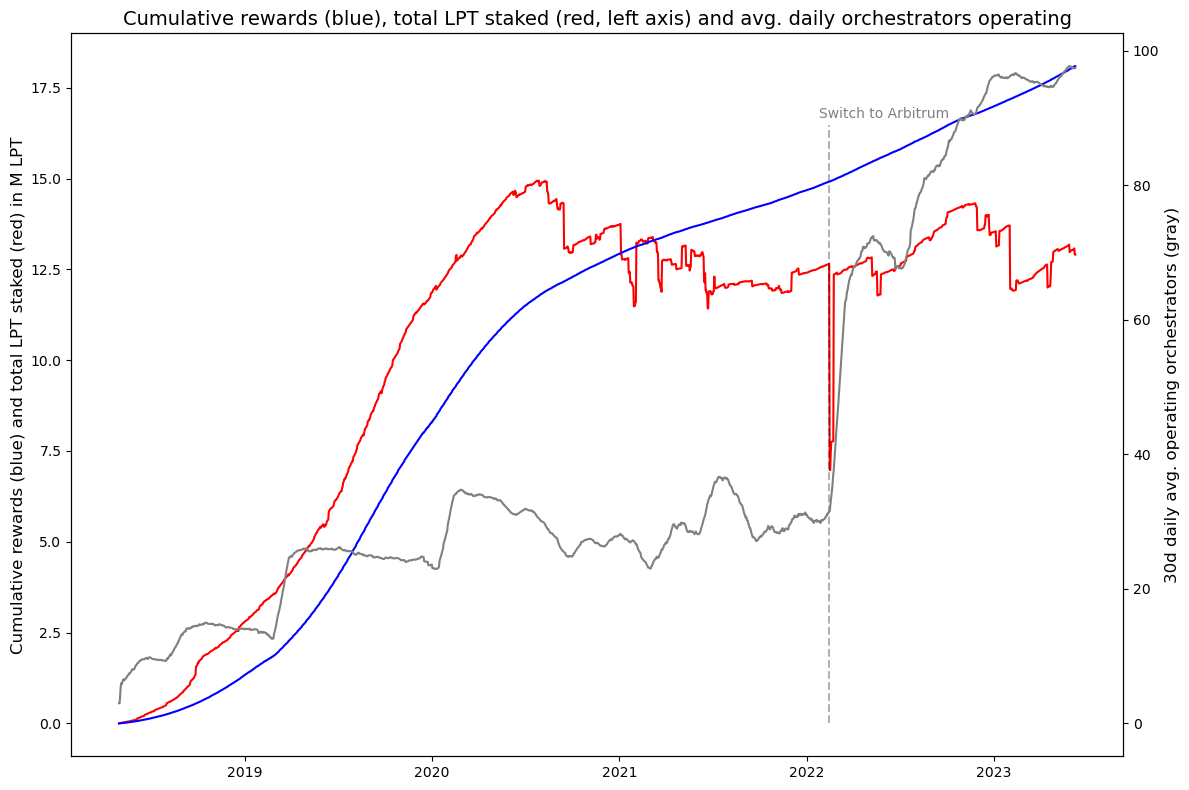

In [159]:
fig,axs = mp.subplots(figsize=(12,8))
df_chart = df_orch_days.copy()
switch_arb = df_orchestrator_limits.datestr.iloc[-1]
switch_arb=datetime.datetime.strptime('2022-02-14','%Y-%m-%d')
# df_chart.loc[df_chart.datestr>switch_arb,'stake_total']=df_chart[df_chart.datestr>switch_arb].stake_total/2
axs.plot(np.array(df_chart.datestr),np.array(df_chart.stake_total)/1000000, color='r')
axs.plot(np.array(df_chart.datestr),np.array(df_chart.rewards_total)/1000000, color='b')
ax2=axs.twinx()

ax2.text(df_chart.datestr.iloc[-500],90,'Switch to Arbitrum',color='gray')

ax2.plot([switch_arb,switch_arb],[0,89], color='k', linestyle='--', alpha=0.3)

ax2.plot(np.array(df_chart.datestr),get_rolling_avg(df_chart.orchestrators,30), color='gray')

axs.set_title('Cumulative rewards (blue), total LPT staked (red, left axis) and avg. daily orchestrators operating', fontsize=14)
axs.set_ylabel('Cumulative rewards (blue) and total LPT staked (red) in M LPT', fontsize=12)
ax2.set_ylabel('30d daily avg. operating orchestrators (gray)', fontsize=12)
fig.tight_layout()
# fig.savefig('charts/overall_network.png')



Text(0, 0.5, 'Number of tickets processed')

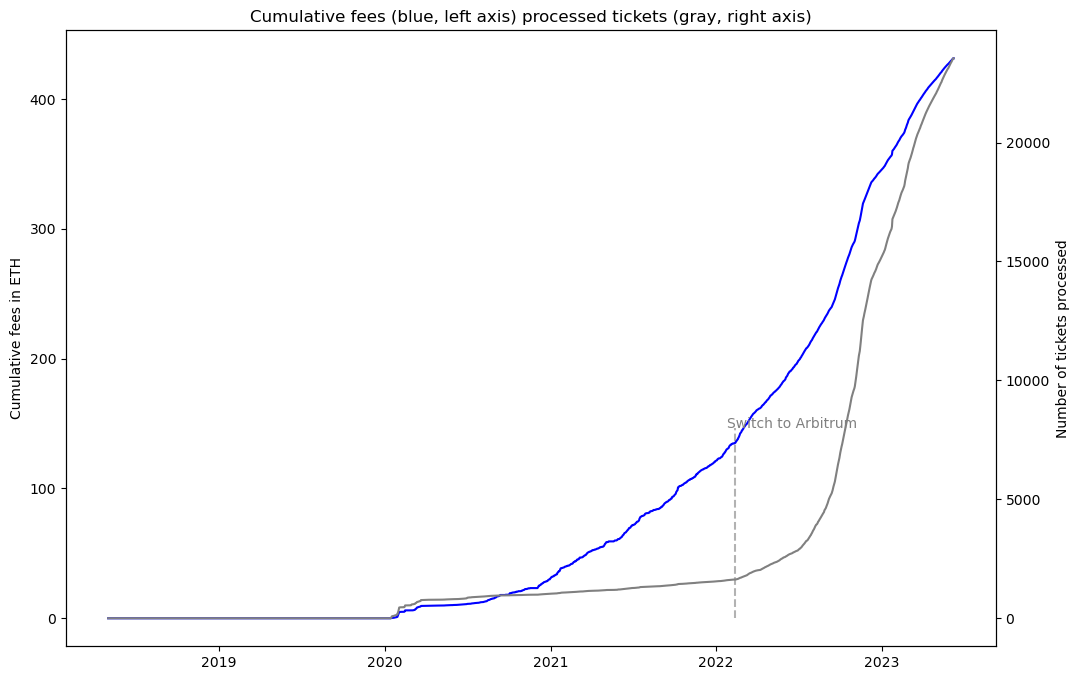

In [102]:
fig,axs = mp.subplots(figsize=(12,8))
df_chart = df_orch_days
axs.plot(np.array(df_chart.datestr),np.array(df_chart.fees_total), color='b')
ax2=axs.twinx()
switch_arb = df_orchestrator_limits.datestr.iloc[-1]
ax2.text(np.array(df_chart.datestr.iloc[-500]),8010,'Switch to Arbitrum',color='gray')

ax2.plot([switch_arb,switch_arb],[0,8000], color='k', linestyle='--', alpha=0.3)

ax2.plot(np.array(df_chart.datestr),np.array(df_chart.tickets_total), color='gray')
axs.set_title('Cumulative fees (blue, left axis) processed tickets (gray, right axis)')
axs.set_ylabel('Cumulative fees in ETH')
ax2.set_ylabel('Number of tickets processed')
# fig.savefig('charts/overall_tickets_fees.png')

In [133]:
df_daily = df_orchestrators_daily.groupby('datestr').agg(
    reward_cut_avg = ('reward_cut','mean'),
    reward_orchestrator_sum = ('rewards_orchestrator','sum'),
    reward_sum = ('rewards','sum'),
    fee_share_avg = ('fee_share','mean'),
    fees_orchestrator_sum = ('fees_orchestrator','sum'),
    fee_sum = ('fees_eth','sum')
).reset_index()
df_daily['reward_cut_act']=df_daily.reward_orchestrator_sum/df_daily.reward_sum
df_daily['fee_share_act']=df_daily.fees_orchestrator_sum/df_daily.fee_sum



Text(0, 0.5, 'Fee share')

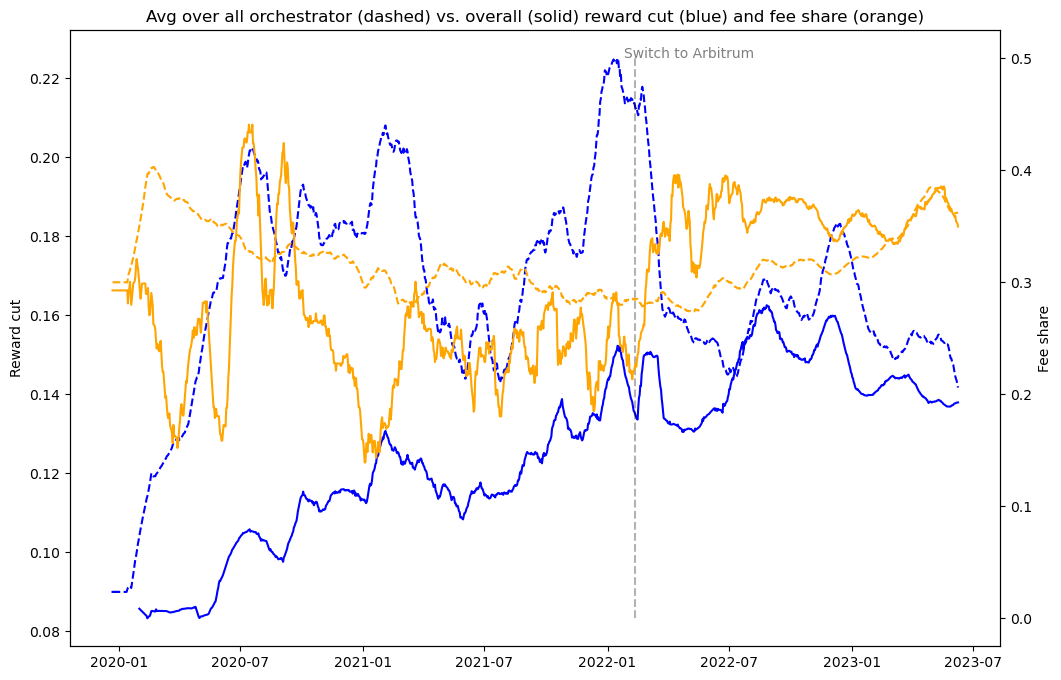

In [140]:
fig,axs = mp.subplots(figsize=(12,8))
df_chart = df_daily.iloc[600:].copy()
axs.plot(np.array(df_chart.datestr),np.array(get_rolling_avg(np.array(df_chart.reward_cut_avg),30)), color='b',linestyle='--')
axs.plot(np.array(df_chart.datestr),np.array(get_rolling_avg(np.array(df_chart.reward_cut_act),30)), color='b')
ax2=axs.twinx()
switch_arb = df_orchestrator_limits.datestr.iloc[-1]
ax2.text(np.array(df_chart.datestr.iloc[-500]),0.5,'Switch to Arbitrum',color='gray')

ax2.plot([switch_arb,switch_arb],[0,0.5], color='k', linestyle='--', alpha=0.3)

ax2.plot(np.array(df_chart.datestr),np.array(get_rolling_avg(np.array(df_chart.fee_share_avg),30)), color='orange',linestyle='--')
ax2.plot(np.array(df_chart.datestr),np.array(get_rolling_avg(np.array(df_chart.fee_share_act.fillna(df_chart.fee_share_act.mean())),30)), color='orange')
axs.set_title('Avg over all orchestrator (dashed) vs. overall (solid) reward cut (blue) and fee share (orange)')
axs.set_ylabel('Reward cut')
ax2.set_ylabel('Fee share')
# # fig.savefig('charts/overall_tickets_fees.png')

In [81]:
#looking deeper into orchestrators - needs further work
df_orchestrators = df_orchestrators_daily_usd.groupby(['orchestrator','status','chain']).agg(
    rewards_lpt = ('rewards','sum'),
    rewards_usd = ('rewards_usd','sum'),
    rewards_orch_lpt = ('rewards_orchestrator','sum'),
    rewards_orch_usd = ('rewards_orchestrator_usd','sum'),
    stake_lpt = ('stake_lpt','sum'),
    stake_orchestrator_max = ('stake_lpt_orchestrator_cs','max'),
    stake_usd = ('stake_usd','sum'),
    fees_eth = ('fees_eth','sum'),
    fees_usd = ('fees_usd','sum'),
    fees_orch_usd = ('fees_orchestrator','sum'),
    start_date = ('datestr','min'),
    last_date = ('datestr','max'),
    num_tickets = ('num_tickets','sum'),
    age_in_days = ('age_in_days','max')
).reset_index()

df_orchestrators['rank_active'] = 1000
df_orchestrators.loc[df_orchestrators.status=='Activated','rank_active'] = df_orchestrators[df_orchestrators.status=='Activated'].fees_eth.rank(ascending=False)
df_orchestrators['rank_inactive'] = 1000
df_orchestrators.loc[df_orchestrators.status!='Activated','rank_inactive'] = df_orchestrators[df_orchestrators.status!='Activated'].fees_eth.rank(ascending=False)


# df_orchestrators = df_orchestrators.merge(df_transcoders[['transcoder_clean','age_in_day']])


In [82]:
df_orchestrators_both = df_orchestrators.groupby(['orchestrator']).agg(
    rewards_lpt = ('rewards_lpt','sum'),
    rewards_usd = ('rewards_usd','sum'),
    rewards_orch_usd = ('rewards_orch_usd','sum'),
    # stake_lpt = ('stake_lpt','sum'),
    # stake_orchestrator_max = ('stake_lpt_orchestrator_cs','max'),
    # stake_usd = ('stake_usd','sum'),
    fees_eth = ('fees_eth','sum'),
    fees_usd = ('fees_usd','sum'),
    fees_orch_usd = ('fees_orch_usd','sum'),
    # start_date = ('datestr','min'),
    # last_date = ('datestr','max'),
    num_tickets = ('num_tickets','sum'),
    age_in_days = ('age_in_days','sum')
).reset_index()

# df_orchestrators['profit'] = (df_orchestrators.rewards_orch_usd + df_orchestrators.fees_orch_usd - df_orchestrators.cost_fix_cs - df_orchestrators.cost_variable_sum)/1000

df_orchestrators_both['rank_active'] = df_orchestrators_both.fees_eth.rank(ascending=False)
# df_orchestrators_both.loc['rank_active'] = df_orchestrators_both.fees_eth.rank(ascending=False)
# df_orchestrators_both['rank_inactive'] = 1000
# df_orchestrators_both.loc[df_orchestrators_both.status!='Activated','rank_inactive'] = df_orchestrators_both[df_orchestrators_both.status!='Activated'].fees_eth.rank(ascending=False)


# df_orchestrators = df_orchestrators.merge(df_transcoders[['transcoder_clean','age_in_day']])


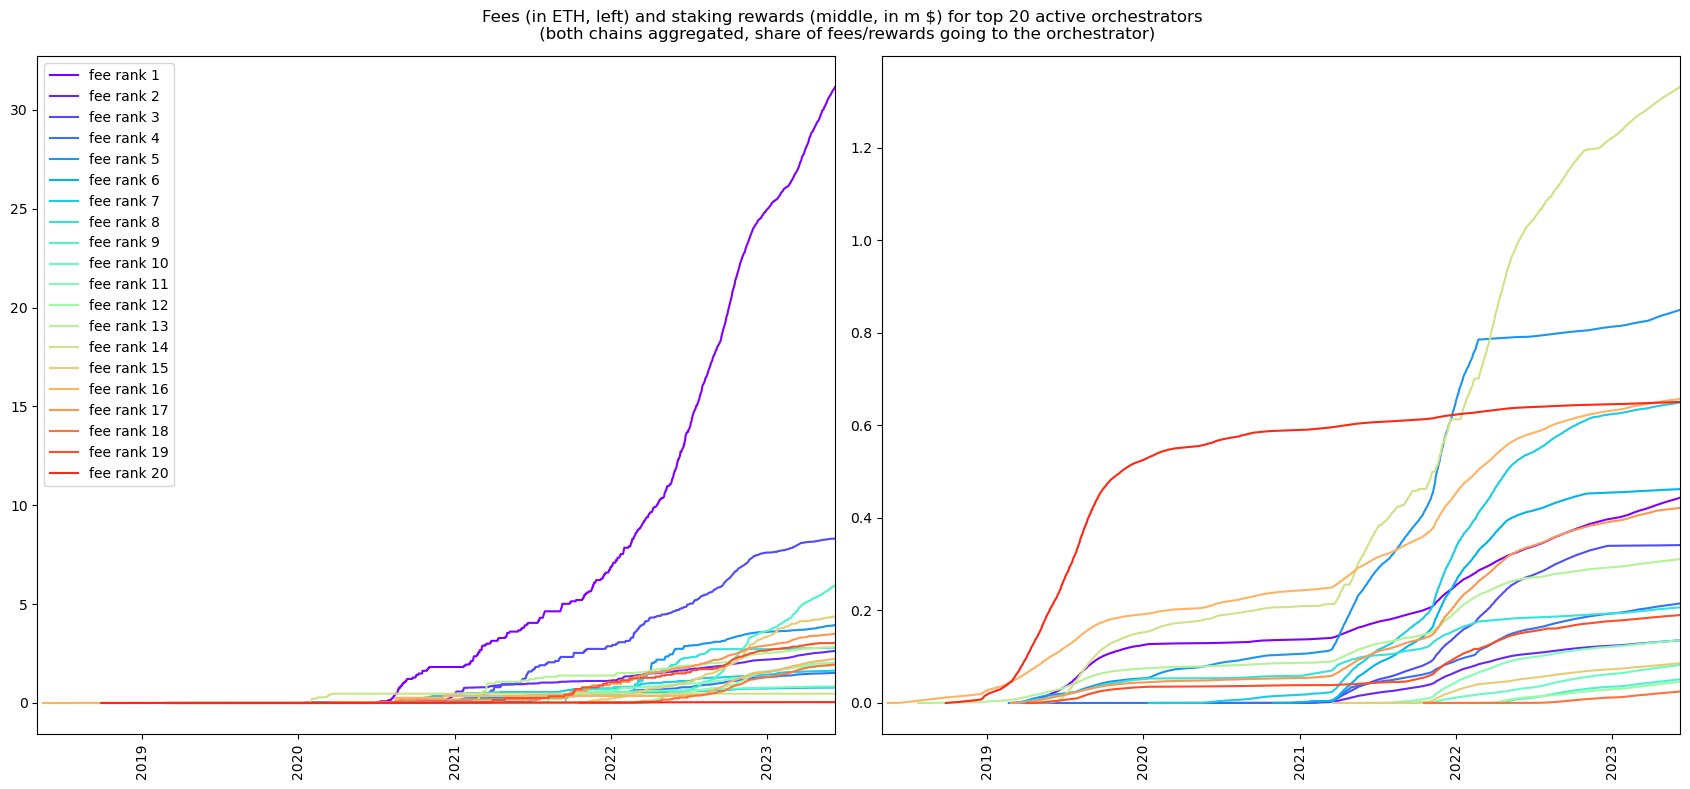

In [85]:
status = 'active'
num_ranks = 21
num_cols = 2
colors = cm.rainbow(np.linspace(0, 1, num_ranks))
fig,axs = mp.subplots(1,num_cols,figsize=(17,8))
xcol1 = 'fees_orchestrator'
xcol2 = 'rewards_orchestrator_usd'
# xcol3='...'
for i,c in zip(range(1,num_ranks),colors):
    df_chart = df_orchestrators_daily_usd[df_orchestrators_daily_usd.orchestrator==df_orchestrators_both[df_orchestrators_both['rank_' + status]==i].orchestrator.iloc[0]].sort_values(by='datestr').reset_index()
    df_chart[xcol1 + '_total']=np.cumsum(df_chart[xcol1])
    df_chart[xcol2 + '_total']=np.cumsum(df_chart[xcol2])/1000000
    # df_chart[xcol3 + '_total']=np.cumsum(df_chart[xcol3])/1000000
    axs[0].plot(np.array(df_chart.datestr),np.array(df_chart[xcol1 + '_total']), label=('fee rank ' + str(i)), color=c)
    axs[0].legend()
    axs[0].tick_params(axis='x',rotation=90)
    
    axs[1].plot(np.array(df_chart.datestr),np.array(df_chart[xcol2 + '_total']), label=('fee rank ' + str(i)), color=c)
    axs[1].tick_params(axis='x',rotation=90)
    
    # axs[2].plot(df_chart.datestr,df_chart[xcol3 + '_total'], label=('fee rank ' + str(i)), color=c)
    # axs[2].tick_params(axis='x',rotation=90)

for i in range(0,num_cols):
    axs[i].set_xlim(min(df_orch_days.datestr),max(df_orch_days.datestr))

fig.suptitle('Fees (in ETH, left) and staking rewards (middle, in m $) for top ' + str(num_ranks-1) + ' ' + str(status) +  ' orchestrators \n (both chains aggregated, share of fees/rewards going to the orchestrator)')
fig.tight_layout()
# fig.savefig('charts/top20_orch_fees_profit.png')